In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [47]:
BASE_DIR = "LEGO Minifigure Image Classification_"
INDEX_FILE = "index.csv"
META_FILE = "metadata.csv"

In [49]:
index_df = pd.read_csv(INDEX_FILE)
metadata_df = pd.read_csv(META_FILE, encoding="latin1")

In [50]:
index_df['path'] = index_df['path'].str.replace('/', os.sep).str.strip()

In [51]:
print("Total images:", len(index_df))
print(index_df.head())

Total images: 371
                  path  class_id
0  marvel\0001\001.jpg         1
1  marvel\0001\002.jpg         1
2  marvel\0001\003.jpg         1
3  marvel\0001\004.jpg         1
4  marvel\0001\005.jpg         1


In [40]:
merged_df = index_df.merge(metadata_df, on="class_id", how="left")
print("\nSample merged data:")
merged_df.head()


Sample merged data:


,path,class_id,lego_ids,lego_names,minifigure_name
0,marvel/0001/001.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,marvel/0001/002.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
2,marvel/0001/003.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
3,marvel/0001/004.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
4,marvel/0001/005.jpg,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN


In [76]:
# Print all unique class names
print("🔹 Unique Classes in Dataset:")
classes = list(train_generator.class_indices.keys())
for i, cls in enumerate(classes, start=1):
    print(f"{i}. {cls}")

print(f"\nTotal Classes: {len(classes)}")


🔹 Unique Classes in Dataset:
1. ANAKIN SKYWALKER
2. AUNT MAY
3. BLACK WIDOW
4. BOBA FETT
5. CAPTAIN AMERICA
6. CARA DUNE
7. DARTH VADER
8. EMPEROR PALPATINE
9. FIREFIGHTER
10. GENERAL GRIEVOUS
11. GHOST SPIDER
12. HAN SOLO
13. HARRY POTTER
14. IRON MAN MK 1
15. IRON MAN MK 41
16. IRON MAN MK 5
17. IRON MAN MK 50
18. JANNAH
19. KLATOOINIAN RAIDER 1
20. KLATOOINIAN RAIDER 2
21. KYLO REN
22. LUKE SKYWALKER
23. MACE WINDU
24. MYSTERIO
25. OBI-WAN KENOBI
26. OUTRIDER 1
27. OUTRIDER 2
28. OWEN GRADY
29. R2-D2
30. RON WEASLEY
31. SPIDER-MAN
32. TASKMASTER
33. THE MANDALORIAN
34. TRACKER TRAQUEUR RASTREADOR
35. VENOM
36. YELENA BELOVA
37. YODA

Total Classes: 37


In [306]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 37
EPOCHS = 50
LEARNING_RATE = 0.001

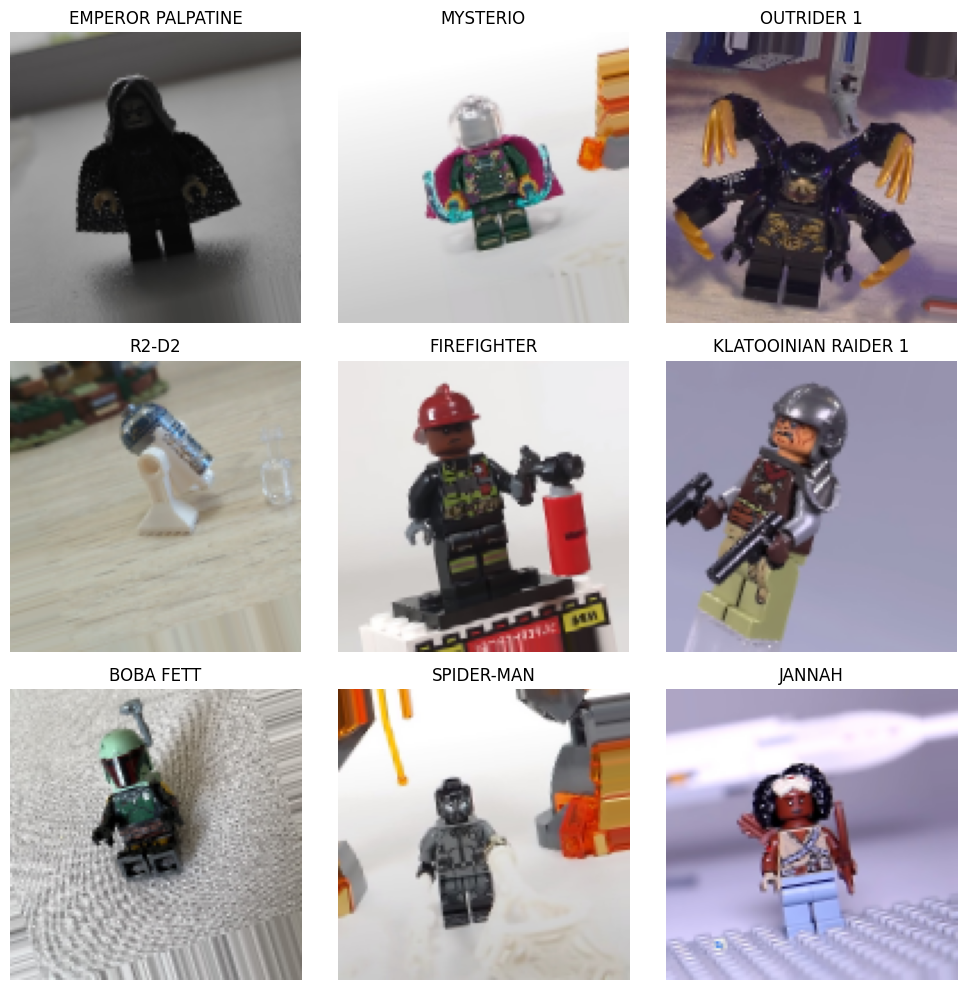

In [154]:
images, labels = next(train_generator)

# Convert one-hot encoded labels back to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}  # reverse mapping
label_names = [class_indices[label.argmax()] for label in labels]

# Plot the images with class names
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"{label_names[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [181]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split

In [261]:
train_df, val_df = train_test_split(
    merged_df,
    test_size=0.2,
    stratify=merged_df['minifigure_name'],  # Ensures all classes in both splits
    random_state=42
)

print(f"Train DataFrame: {len(train_df)} samples")
print(f"Val DataFrame: {len(val_df)} samples")

Train DataFrame: 296 samples
Val DataFrame: 75 samples


In [262]:
# Check class distribution
print("\nClass distribution in splits:")
print(f"  Train unique classes: {train_df['minifigure_name'].nunique()}")
print(f"  Val unique classes: {val_df['minifigure_name'].nunique()}")


Class distribution in splits:
  Train unique classes: 37
  Val unique classes: 37


In [275]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

In [264]:
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0  # ONLY rescaling, NO augmentation!
)

In [265]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,      
    directory=BASE_DIR,
    x_col="path",
    y_col="minifigure_name",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


Found 296 validated image filenames belonging to 37 classes.


In [266]:
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,         # Use val_df
    directory=BASE_DIR,
    x_col="path",
    y_col="minifigure_name",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 75 validated image filenames belonging to 37 classes.


In [267]:
print(f"\n✅ Train samples: {train_generator.n}")
print(f"✅ Val samples: {val_generator.n}")
print(f"✅ Total: {train_generator.n + val_generator.n}")



✅ Train samples: 296
✅ Val samples: 75
✅ Total: 371


In [298]:
model = Sequential([
    Input(shape=(128, 128, 3)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [299]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_49 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_50 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_51 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 37)                  │           4,773 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,292,453 (16.37 MB)

 Trainable params: 4,292,453 (16.37 MB)

 Non-trainable params: 0 (0.00 B)

In [300]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy'),
        keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_accuracy')
    ]
)

In [301]:
callbacks = [
    # Early stopping: Stop when validation loss stops improving
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),
    
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    
    # Save best model
    ModelCheckpoint(
        'best_lego_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]


In [302]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [307]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print(f"Final Training Accuracy:   {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss:       {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss:     {history.history['val_loss'][-1]:.4f}")
print(f"Best Validation Accuracy:  {max(history.history['val_accuracy']):.4f}")
print(f"Total Epochs Run:          {len(history.history['accuracy'])}")

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.0267 - loss: 3.5901 - top_3_accuracy: 0.1265 - top_5_accuracy: 0.2015    
Epoch 1: val_accuracy did not improve from 0.05333
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 774ms/step - accuracy: 0.0273 - loss: 3.5918 - top_3_accuracy: 0.1255 - top_5_accuracy: 0.1997 - val_accuracy: 0.0533 - val_loss: 3.5926 - val_top_3_accuracy: 0.1200 - val_top_5_accuracy: 0.2000 - learning_rate: 5.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.0508 - loss: 3.5978 - top_3_accuracy: 0.1500 - top_5_accuracy: 0.2202 
Epoch 2: val_accuracy did not improve from 0.05333
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 651ms/step - accuracy: 0.0523 - loss: 3.5972 - top_3_accuracy: 0.1514 - top_5_accuracy: 0.2226 - val_accuracy: 0.0400 - val_loss: 3.5726 - val_top_3_accuracy: 0.1067 - val_top_5_accuracy: 0.2667 - learning_rate: 5.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.0688 - loss: 3.5571 - top_3_accuracy: 0.1560 - to

## Task 3

In [342]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [344]:
BASE_DIR = r"E:\ridzz\uni folder\hacktoberfest\task 4\LEGO Minifigure Image Classification_"

In [345]:
test_df = pd.read_csv("test.csv")
test_df['path'] = test_df['path'].apply(lambda x: f"{BASE_DIR}\\{x}")

In [346]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='class_id',
    target_size=(128, 128),
    batch_size=32,
    class_mode='raw',   # use raw labels for numeric IDs
    shuffle=False
)

Found 79 validated image filenames.


In [347]:
pred_probs = model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.labels.astype(int)


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step



✅ Test Accuracy: 0.0380

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.50      0.50      0.50         2
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.20      1.00      0.33         1
          16       0.00      0

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531:

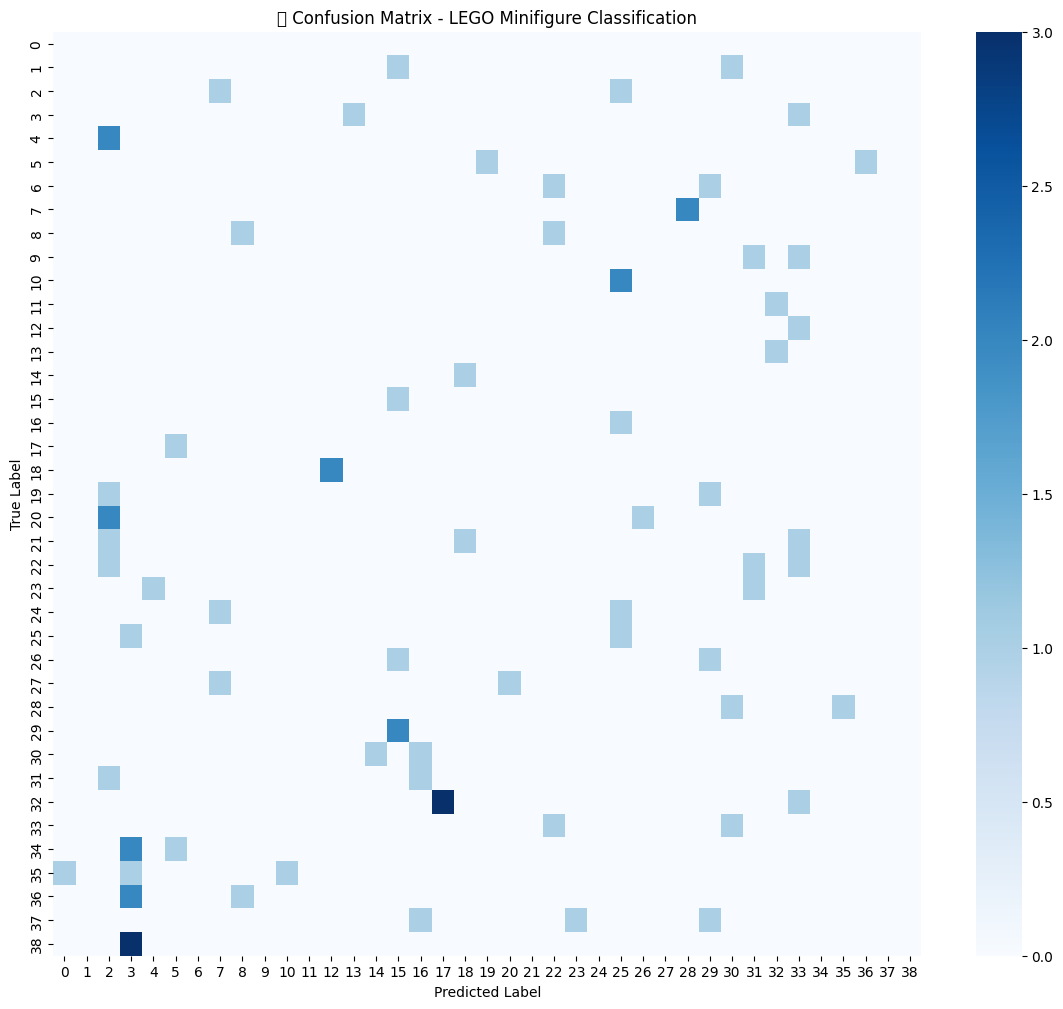

In [348]:
# --- Accuracy ---
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# --- Classification Report ---
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("🧩 Confusion Matrix - LEGO Minifigure Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# Task4

## Visualize Feature Maps

In [349]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
import tensorflow as tf

In [350]:
img_path = test_df['path'].iloc[0]  # or any path you like

In [351]:
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)


In [352]:
# Select convolutional layers to visualize
conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
print(f"Total convolutional layers: {len(conv_layers)}")


Total convolutional layers: 3


In [353]:
# Create a model that outputs each conv layer’s activations
feature_model = Model(inputs=model.inputs, outputs=[l.output for l in conv_layers])

In [354]:
# Get activations
feature_maps = feature_model.predict(img_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1942']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


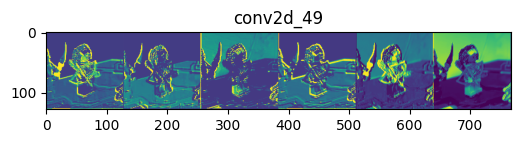

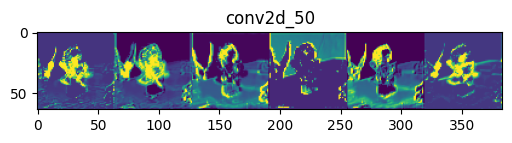

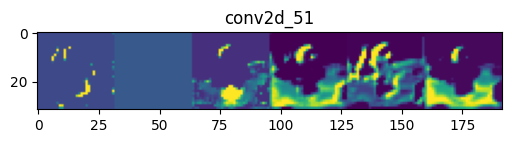

In [355]:
# Visualize first few filters of each layer
for layer_name, fmap in zip([l.name for l in conv_layers], feature_maps):
    n_features = fmap.shape[-1]
    size = fmap.shape[1]
    display_grid = np.zeros((size, size * 6))  # show 6 filters per row
    for i in range(6):
        x = fmap[0, :, :, i]
        x -= x.mean()
        x /= (x.std() + 1e-5)
        x *= 64
        x += 128
        x = np.clip(x, 0, 255).astype('uint8')
        display_grid[:, i * size:(i + 1) * size] = x

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

## Task 5

In [389]:
params = [
    {"lr": 0.001, "dropout_rate": 0.5, "dense_units": 128},
    {"lr": 0.0005, "dropout_rate": 0.3, "dense_units": 128},
    {"lr": 0.001, "dropout_rate": 0.5, "dense_units": 256},
]

results = []

for p in params:
    print(f"\n🔹 Training with params: {p}")
    model = model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=5,
        verbose=1
    )
    val_acc = history.history['val_accuracy'][-1]
    results.append({**p, "val_accuracy": val_acc})



🔹 Training with params: {'lr': 0.001, 'dropout_rate': 0.5, 'dense_units': 128}
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 807ms/step - accuracy: 0.3625 - loss: 2.1502 - top_3_accuracy: 0.6205 - top_5_accuracy: 0.7429 - val_accuracy: 0.4000 - val_loss: 2.3322 - val_top_3_accuracy: 0.6800 - val_top_5_accuracy: 0.7600
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 743ms/step - accuracy: 0.3790 - loss: 2.1096 - top_3_accuracy: 0.6489 - top_5_accuracy: 0.7464 - val_accuracy: 0.3867 - val_loss: 2.3782 - val_top_3_accuracy: 0.6667 - val_top_5_accuracy: 0.7600
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 670ms/step - accuracy: 0.4368 - loss: 1.9491 - top_3_accuracy: 0.6880 - top_5_accuracy: 0.8025 - val_accuracy: 0.4000 - val_loss: 2.3275 - val_top_3_accuracy: 0.6800 - val_top_5_accuracy: 0.7600
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 777ms/step - accuracy: 0.4190 - loss: 2.0467 - top_3_accuracy: 0.6351 - top_5_accuracy: 0.7843 - val_accuracy: 0.4267 - val_loss: 2.2830 - val_top_3_accuracy: 0.6533 - val_to

In [390]:
df = pd.DataFrame(results)
print(df)

       lr  dropout_rate  dense_units  val_accuracy
0  0.0010           0.5          128      0.373333
1  0.0005           0.3          128      0.413333
2  0.0010           0.5          256      0.426667


In [391]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_generator.classes, y_pred, target_names=list(val_generator.class_indices.keys())))


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
                             precision    recall  f1-score   support

           ANAKIN SKYWALKER       0.00      0.00      0.00         2
                   AUNT MAY       0.67      1.00      0.80         2
                BLACK WIDOW       0.50      0.50      0.50         2
                  BOBA FETT       0.12      0.50      0.20         2
            CAPTAIN AMERICA       0.67      1.00      0.80         2
                  CARA DUNE       0.00      0.00      0.00         1
                DARTH VADER       0.00      0.00      0.00         2
          EMPEROR PALPATINE       0.00      0.00      0.00         2
                FIREFIGHTER       0.50      0.50      0.50         2
           GENERAL GRIEVOUS       1.00      0.50      0.67         2
               GHOST SPIDER       1.00      0.50      0.67         2
                   HAN SOLO       0.00      0.00      0.00         2
               HARRY POTTER       0.00      0.00      0.00     

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.

In [393]:
model.save("lego_model.keras") 